In [1]:
import matplotlib.pyplot as plt
import contextily as ctx
import networkx as nx
import osmnx as ox
import geopandas
import pandas
import folium

#### what i dey do?
I want to present a proof of concept program that can produce a
reproducible map of any area and then do some simple network analysis
for me. the goal is to base my final year project on this so adios merhn!!

- consistent and chainable object interface for producing map
- simple analysis methods like shortest path and then some
- static plot and interactive plot of area with buildings if the
   area is not too large

In [54]:
    def plot_args(nrows=1,
                  ncols=1,
                  figsize=(10, 10),
                  axis=True,
                  tight_layout=True,
                  edges=True,
                  nodes=True,
                  
                  # styles for customizing lines and points
                  line_color='gray',
                  linewidth=0.7,
                  line_alpha=0.5,
                  line_style='-',
                  node_color='gray',
                  node_size=20,
                  node_alpha=None,
                  title="",
                  
                  # othe stuff
                  tiles=False,
                  filepath=None,
                  static_tile=ctx.providers.CartoDB.Positron,
                  interactive_tile='OpenStreetMap',
                  customize_plot=None) -> dict:
        """collects all the args required to do a static/interactive plot
        
        this is passed to all the plotting functions that rely these
        parameters for plotting
        
        Parameters
        -----------
         nrows=1 : int
             number of rows plot
         ncols=1 : int
             number of columns for plot
         figsize=(10, 10) : tuple[int, int]
             figure size of each graph space
         axis=True : bool
             show the axis of the resulting plot
         tight_layout=False : bool
             make plot a tight layout
         edges=True : bool
             plot edges/line of the network graph
         nodes=True : bool
             plot nodes/intersection of network graph

         line_color='gray' : str
             color of edges in plot
         node_color='gray' str
             color of nodes / intersection points in plot
         linewidth=0.7 : float | None
             line width of edges in plot
         line_alpha=0.5 : float | None
             opacity of edges in plot
         node_alpha=None : float | None
             opacity of the nodes in graph plot

         filepath=None : str | None
             path to file to save resulting plot
         tiles=False : bool
             add a basemap tile from an online tile service using contextily
             for static plots and folium for interactive plots
         title=None : str | None
             title of the plot
         static_tile=ctx.providers.CartoDB.Positron : xyzservices.lib.TileProvider
             online tile service to use for static plots
             see `ctx.providers` for more providers from contextily
         interactive_tile='OpenStreetMap' : str
             service to use for interactive plots
         customize_func=None : Func | None
             callback of signature `Func[fig, ax] -> None`, used to customize
             plot to the callers satisfaction
         """
        return locals()

In [70]:
def load_csv(sep=',', *files, **kwargs):
    """load csv file from filesystem"""
    assert len(files), "load_csv: expecting two files"
    assert all([os.path.isfile(f) for f in files]), \
        "load_csv: arguments must be valid csv files"
    return tuple((pandas.read_csv(file, sep=sep **kwargs) for file in files))

class Route():
    """route allows you to load a point or bunch of them
    
    this allows you to do shortest path analysis and plot them
    on a bigger graph
    """
    
    def __init__(self, point_type, origin_point, destination_point):
        """
        NB: [origin/destination]_point can be a
               1. tupe[float, float] | list[tupe[float, float]] -> (lat, long)
               2. shapely.Point | list[shapely.Point]
               3. geocodable string | list[str]
               4. a csv file of x, y coordinates
               
            coordinates are in the form (lat, long)
                x -> long
                y -> lat
                
        Parameters
        -----------
        point_type('csv_file', 'coords') : str
            specify how the data of the route
            should be loaded
        """
        
        self.origin, self.destination = None
        
        match point_type:
            case 'csv_file':
                files = load_csv(origin_point, destination_point)
            case 'coords':
                pass
            case 'coords_list':
                pass

In [65]:
class Graph:
    """An all in one tool to make reproducible network analysis easy
    
    Graph is the main data downloader using the osmnx tool to
    download data from openstreetmap. Abstract layer that
    subscribes to the same idea of reproducible download and
    analysis of data. Also provides a chainable api that makes
    things easy to do.
    
    Should allow you to download data using all the methods available
    in osmnx
    
    There are various ways to download using the osmnx tool, Placer.download
    method will right function to download the data with. It takes the
    following parameters related to data download
    
    Parameters
    ----------
    from_bbox: bool    -> use osmnx.graph_from_bbox
    from_address: bool -> use osmnx.graph_from_address
    from_place: bool   -> use osmnx.graph_from_place
    from_point: bool   -> use osmnx.graph_from_point
    from_polygon: bool   -> use osmnx.graph_from_polygon
    """
    
    def __init__(self,
                 from_bbox=False,
                 from_place=False,
                 from_address=False,
                 from_polygon=False,
                 from_point=False,
                 custom_download=False, func=None,
                 coord_with_distance=False,
                 address_with_distance=None,
                 place_names=None
                ):
        
        # G is a networkx.MultiDiGraph that osmnx produces
        self.G=None
        
        # nodes in the graph
        self.nodes=None
        
        # edges in the graph
        self.edges=None
        
        # boolean value to represent is graph is projected
        self.__projected = False
        
        # holds osmnx function to use to download graph
        self.downloader = None
        
        #TODO: shortest path analysis and gathering of stats
        # present this work by next week to TAs and get a lecturer
        # to start guiding me on what to do next.
        # download geometries in the graph extent and optionally
        # provide parameters to plot functions to plot them
        """
        i might do a Geometry type that takes plot arguments
        to customize it when plotting
        """
        self.geometries = []
        
        self.custom_download = custom_download
        if custom_download and func is not None:
            self.downloader = func
        elif from_bbox:
            self.downloader = ox.graph_from_bbox
        elif from_address:
            self.downloader = ox.graph_from_address
        elif from_place:
            self.downloader = ox.graph_from_place
        elif from_point:
            self.downloader = ox.graph_from_point
        elif from_polygon:
            self.downloader = ox.graph_from_polygon
        
    def download(self, *args, **kwargs):
        """Download graph data from openstreetmap using osmnx
        
        download uses the appropriate function based on the parameters
        that the graph object is initialized with.
        
        Parameters
        -----------
        """
        
        if self.custom_download and self.downloader is not None:
            self.G = self.downloader()
            return
        
        self.G = self.downloader(*args, **kwargs)
        return self
    

    def graph(self):
        """graph returns the downloaded graph data from osmnx"""
        if self.G is None and self.custom_download:
            self.G = self.downloader()
        return self.G
    
    def project(self, crs=None):
        """project graph to another CRS.
        
        if the `crs` parameter is None, osmnx projects graph to the UTM zone
        in which the graph's centroid lies
        """
        self.G = ox.project_graph(self.G, to_crs=crs)
        self.__projected = True
        
        # reproject edges and nodes if they exist in
        # the previous CRS
        if self.nodes:
            self.get_nodes()  
        if self.edges:
            self.get_edges()

        return self
    
    def get_nodes(self):
        self.nodes = ox.graph_to_gdfs(self.G, nodes=True, edges=False)
        return self
    
    def get_edges(self):
        self.nodes, self.edges = ox.graph_to_gdfs(self.G, nodes=False, edges=True)
        return self
    
    def nodes_and_edges(self):
        if not self.nodes and not self.edges:
            self.nodes, self.edges = ox.graph_to_gdfs(self.G)
        return self
    
    def get_crs(self):
        if self.nodes is None:
            self.nodes()
        return self.nodes.crs
    
    def with_geometry(self):
        """download geometries of the extent of the graph"""
        return self

    def default_plot(self, graph=None):
        """plot uses the osmnx.plot_graph method to do exploratory plot
        of the graph. It recieves an optional `graph` parameter to plot
        instead of the one associated with the object.
        
        Parameter
        ---------
        graph: networkx.MultiDiGraph
        """
        if graph is not None:
            return ox.plot_graph(graph)
        # do a plot
        g = self.graph()
        if g is not None:
            return ox.plot_graph(g)
        
    
    def __get_fig_ax(self, args):
        return plt.subplots(nrows=args['nrows'],
                          ncols=args['ncols'],
                          figsize=args['figsize'])
    
    
        
    def static_plot(self, *args, **plot_kwargs):
        """do a static plot of the graph
        
        Returns:
        --------
        fig, ax : matplotlib.pyplot (Axes, Figure)
        
        """
        args = plot_args(**plot_kwargs)
        fig, ax = self.__get_fig_ax(args)
        # TODO: ax could be anything depending on nrows, ncols.. check that!
        
        # plot edges in network
        if args['nodes']:
            if self.nodes is None:
                self.get_nodes()
                # TODO: make args['markersize'] changeable
            self.nodes.plot(ax=ax, color=args['node_color'],
                           alpha=args['node_alpha'],
                           markersize=args['node_size'])
        
        # plot the edges in graph / street network
        if args['edges']:
            if self.edges is None:
                self.get_edges()
            self.edges.plot(ax=ax, color=args['line_color'],
                   linewidth=args['linewidth'],
                    alpha=args['line_alpha'])
        
        # plot the axis
        if not args['axis']:
            ax.axis('off')
            
        if args['title']:
            ax.set_title(args['title'])
        if args['tight_layout']:
            plt.tight_layout()
        
        # add basemap
        if args['tiles'] and (crs := self.get_crs()) is not None:
                ctx.add_basemap(ax, crs=crs, source=args['static_tile'])
        
        # save the resulting plot
        if args['filepath'] is not None:
            plt.savefig(args['filepath'])
        
        plt.show()
        return fig, ax

    def interactive_plot(self, *args, **kwargs):
        """do an interactive plot of the map"""
        args = plot_args(*args, **kwargs)
        return args

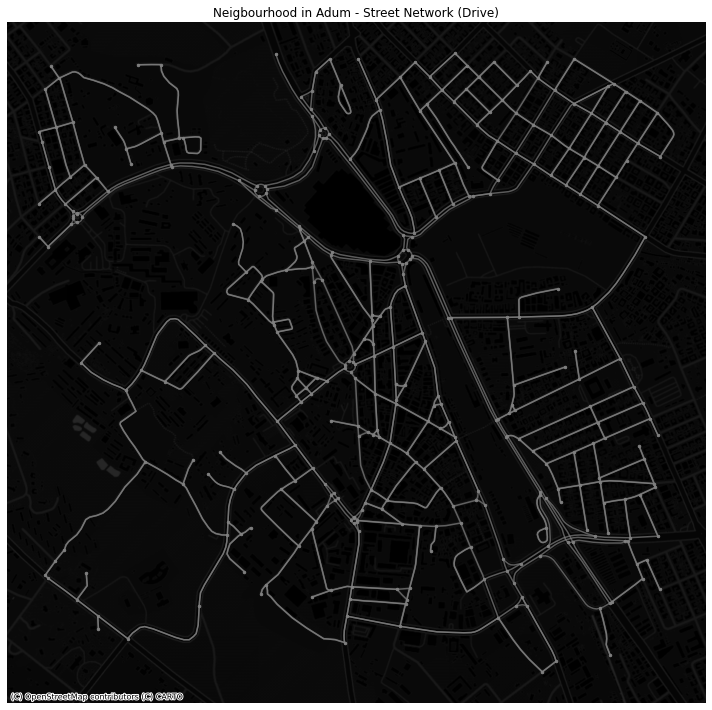

In [66]:
adum = Graph(from_point=True)
_ = adum.download((6.6942926, -1.6233319), dist=1000, network_type='drive') \
    .project() \
    .nodes_and_edges() \
    .static_plot(tiles=True, linewidth=1.5,
                 axis=False, node_size=6,
                 line_alpha=0.7,
                 static_tile=ctx.providers.CartoDB.DarkMatterNoLabels,
                 title='Neigbourhood in Adum - Street Network (Drive)',
                 filepath='adum_neighbourhood_street_drive.png')

In [46]:
ctx.providers.CartoDB

{'Positron': {'url': 'https://{s}.basemaps.cartocdn.com/{variant}/{z}/{x}/{y}{r}.png',
  'html_attribution': '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors &copy; <a href="https://carto.com/attributions">CARTO</a>',
  'attribution': '(C) OpenStreetMap contributors (C) CARTO',
  'subdomains': 'abcd',
  'max_zoom': 20,
  'variant': 'light_all',
  'name': 'CartoDB.Positron'},
 'PositronNoLabels': {'url': 'https://{s}.basemaps.cartocdn.com/{variant}/{z}/{x}/{y}{r}.png',
  'html_attribution': '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors &copy; <a href="https://carto.com/attributions">CARTO</a>',
  'attribution': '(C) OpenStreetMap contributors (C) CARTO',
  'subdomains': 'abcd',
  'max_zoom': 20,
  'variant': 'light_nolabels',
  'name': 'CartoDB.PositronNoLabels'},
 'PositronOnlyLabels': {'url': 'https://{s}.basemaps.cartocdn.com/{variant}/{z}/{x}/{y}{r}.png',
  'html_attribution': '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors &copy; <a href="https://carto.com/attributions">CARTO</a>',
  'attribution': '(C) OpenStreetMap contributors (C) CARTO',
  'subdomains': 'abcd',
  'max_zoom': 20,
  'variant': 'light_only_labels',
  'name': 'CartoDB.PositronOnlyLabels'},
 'DarkMatter': {'url': 'https://{s}.basemaps.cartocdn.com/{variant}/{z}/{x}/{y}{r}.png',
  'html_attribution': '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors &copy; <a href="https://carto.com/attributions">CARTO</a>',
  'attribution': '(C) OpenStreetMap contributors (C) CARTO',
  'subdomains': 'abcd',
  'max_zoom': 20,
  'variant': 'dark_all',
  'name': 'CartoDB.DarkMatter'},
 'DarkMatterNoLabels': {'url': 'https://{s}.basemaps.cartocdn.com/{variant}/{z}/{x}/{y}{r}.png',
  'html_attribution': '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors &copy; <a href="https://carto.com/attributions">CARTO</a>',
  'attribution': '(C) OpenStreetMap contributors (C) CARTO',
  'subdomains': 'abcd',
  'max_zoom': 20,
  'variant': 'dark_nolabels',
  'name': 'CartoDB.DarkMatterNoLabels'},
 'DarkMatterOnlyLabels': {'url': 'https://{s}.basemaps.cartocdn.com/{variant}/{z}/{x}/{y}{r}.png',
  'html_attribution': '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors &copy; <a href="https://carto.com/attributions">CARTO</a>',
  'attribution': '(C) OpenStreetMap contributors (C) CARTO',
  'subdomains': 'abcd',
  'max_zoom': 20,
  'variant': 'dark_only_labels',
  'name': 'CartoDB.DarkMatterOnlyLabels'},
 'Voyager': {'url': 'https://{s}.basemaps.cartocdn.com/{variant}/{z}/{x}/{y}{r}.png',
  'html_attribution': '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors &copy; <a href="https://carto.com/attributions">CARTO</a>',
  'attribution': '(C) OpenStreetMap contributors (C) CARTO',
  'subdomains': 'abcd',
  'max_zoom': 20,
  'variant': 'rastertiles/voyager',
  'name': 'CartoDB.Voyager'},
 'VoyagerNoLabels': {'url': 'https://{s}.basemaps.cartocdn.com/{variant}/{z}/{x}/{y}{r}.png',
  'html_attribution': '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors &copy; <a href="https://carto.com/attributions">CARTO</a>',
  'attribution': '(C) OpenStreetMap contributors (C) CARTO',
  'subdomains': 'abcd',
  'max_zoom': 20,
  'variant': 'rastertiles/voyager_nolabels',
  'name': 'CartoDB.VoyagerNoLabels'},
 'VoyagerOnlyLabels': {'url': 'https://{s}.basemaps.cartocdn.com/{variant}/{z}/{x}/{y}{r}.png',
  'html_attribution': '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors &copy; <a href="https://carto.com/attributions">CARTO</a>',
  'attribution': '(C) OpenStreetMap contributors (C) CARTO',
  'subdomains': 'abcd',
  'max_zoom': 20,
  'variant': 'rastertiles/voyager_only_labels',
  'name': 'CartoDB.VoyagerOnlyLabels'},
 'VoyagerLabelsUnder': {'url': 'https://{s}.basema

xyzservices.lib.TileProvider